In [1]:
# Install GeoPandas, Folium, and other libraries


In [3]:
# Data handling
import pandas as pd
import geopandas as gpd

# GIS & Mapping
import folium
from shapely.geometry import Point

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
# import fastf1
import requests


Formation of Pandas dataframe

Getting the data


*   Circuit Name
*   year
*   crash appearance
*  weather on day of race







In [4]:
import requests

def lap_time_to_seconds(lap_time_str):
    """
    Convert a lap time string (e.g., "1:42.678") into total seconds as a float.
    """
    parts = lap_time_str.split(':')
    if len(parts) == 2:
        minutes = int(parts[0])
        seconds = float(parts[1])
        return minutes * 60 + seconds
    else:
        return float(lap_time_str)

def get_circuit_data(year, round):
    """
    Retrieves race, circuit, and lap timing data from Ergast.

    For lap timing:
      - Lap time data is available from the 1996 season onward.
      - The laps endpoint requires the season, round, and (optionally) lap number:
            e.g., http://ergast.com/api/f1/2011/5/laps/1
      - You can also filter by driver:
            e.g., http://ergast.com/api/f1/2011/5/drivers/alonso/laps/1

    This function:
      1. Gets basic race/circuit info.
      2. Retrieves race results to build a driver-to-team mapping.
      3. Pulls lap times for the race and aggregates them by team.
      4. Computes the average lap time per team.
    """
    # Retrieve basic race and circuit data.
    url = f"http://ergast.com/api/f1/{year}/{round}.json"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        races = data['MRData']['RaceTable']['Races']
        circuit_list = []

        for race in races:
            circuit = race['Circuit']
            circuit_name = circuit['circuitName']
            race_name = race['raceName']
            location = circuit['Location']
            latitude = location['lat']
            longitude = location['long']
            date = race['date']
            time = race.get('time', None)

            # Retrieve race results to map each driver to their team (constructor)
            results_url = f"http://ergast.com/api/f1/{year}/{round}/results.json"
            results_response = requests.get(results_url)
            driver_to_team = {}
            if results_response.status_code == 200:
                results_data = results_response.json()
                races_results = results_data['MRData']['RaceTable']['Races']
                if races_results:
                    race_results = races_results[0]['Results']
                    for res in race_results:
                        driver_id = res['Driver']['driverId']
                        team = res['Constructor']['name']
                        driver_to_team[driver_id] = team
            else:
                print(f"Error retrieving results data: {results_response.status_code}")

            # Retrieve lap timing data.
            # Using the general laps endpoint to get all lap timings for the race.
            laps_url = f"http://ergast.com/api/f1/{year}/{round}/laps.json?limit=2000"
            laps_response = requests.get(laps_url)

            team_lap_times = {}   # Total lap time in seconds for each team.
            team_lap_counts = {}  # Number of laps recorded per team.

            if laps_response.status_code == 200:
                laps_data = laps_response.json()
                if laps_data['MRData']['RaceTable']['Races']:
                    race_laps = laps_data['MRData']['RaceTable']['Races'][0]['Laps']
                    for lap in race_laps:
                        timings = lap.get('Timings', [])
                        for timing in timings:
                            driver_id = timing['driverId']
                            lap_time_str = timing['time']
                            lap_seconds = lap_time_to_seconds(lap_time_str)

                            # Map the driver to their team (default to "Unknown" if not found)
                            team = driver_to_team.get(driver_id, "Unknown")
                            team_lap_times[team] = team_lap_times.get(team, 0) + lap_seconds
                            team_lap_counts[team] = team_lap_counts.get(team, 0) + 1
                else:
                    print("Lap time data not available for this race.")
            else:
                print(f"Error retrieving lap times: {laps_response.status_code}")

            # Compute the rough average lap time (in seconds) per team .
            avg_team_lap_times = {}
            for team, total_time in team_lap_times.items():
                count = team_lap_counts[team]
                avg_team_lap_times[team] = total_time / count if count else None

            # Append the combined data to the list.
            circuit_list.append({
                "circuitName": circuit_name,
                "latitude": latitude,
                "longitude": longitude,
                "year": year,
                "round": round,
                "raceName": race_name,
                "date": date,
                "time": time,
                "team_lap_times": avg_team_lap_times
            })

        return circuit_list
    else:
        print(f"Error: {response.status_code}")
        return []



In [5]:
# Crash TYPES
driver_error = ["Accident", "Collision", "Spun off"]
car_failure = [
    "Engine", "Gearbox", "Transmission", "Clutch", "Hydraulics", "Electrical",
    "Suspension", "Brakes", "Differential", "Overheating", "Radiator", "Tyre",
    "Puncture", "Driveshaft"
]

In [6]:
def get_crash_data(year, round):
    url = f"http://ergast.com/api/f1/{year}/{round}/status.json"
     # Send a GET request
    response = requests.get(url)
    if response.status_code == 200:
      data = response.json()
      statuses = data['MRData']['StatusTable']['Status']
      crash_counts = {
            "Driver Error": 0,
            "Car Failure": 0
      }
      for status in statuses:
        if status['status'] in driver_error:
          crash_counts["Driver Error"] += int(status['count'])
        elif status['status'] in car_failure:
          crash_counts["Car Failure"] += int(status['count'])

      return crash_counts
    else:
      print(f"Error: {response.status_code}")
      return {}

In [7]:
get_crash_data(2024,6)

{'Driver Error': 1, 'Car Failure': 0}

Now that we have the crashes set up. Now we must develop the round to circuit connection from the api

Get time and date data for the weather

In [8]:
get_circuit_data(2024,6)

[{'circuitName': 'Miami International Autodrome',
  'latitude': '25.9581',
  'longitude': '-80.2389',
  'year': 2024,
  'round': 6,
  'raceName': 'Miami Grand Prix',
  'date': '2024-05-05',
  'time': '20:00:00Z',
  'team_lap_times': {'Red Bull': 93.86330000000001,
   'Ferrari': 94.0188,
   'McLaren': 94.2917,
   'Mercedes': 95.46220000000001,
   'Haas F1 Team': 96.1584,
   'RB F1 Team': 96.5927,
   'Aston Martin': 95.99620000000002,
   'Alpine F1 Team': 96.17479999999999,
   'Williams': 96.37239999999998,
   'Sauber': 96.8126}}]

Pandas formation

In [9]:
def circuit_crashes_data (start_year, end_year):

  combined_data = []

  # Loop through years and rounds
  for year in range(start_year, end_year):
    for round_num in range(1, 25):  # Assuming a maximum of 22 rounds per season
        # Get circuit data
        circuit_data = get_circuit_data(year, round_num)
        crash_data = get_crash_data(year, round_num)
        # Get crash data
        if circuit_data:
          combined_entry = circuit_data[0]
          combined_entry.update(crash_data)
          # print(combined_entry)
          combined_data.append(combined_entry)

  return combined_data


# Convert the combined data to a pandas DataFrame





The rounds per season are irregualr to for the primary datagrame the columns are the year and round number

In [10]:
records = circuit_crashes_data(2015, 2025)

AttributeError: 'list' object has no attribute 'to_csv'

Personal choice to incude 6 instead of 5 becuse there were a lot of rookies this year but stil want a 5 year of the driver i have been most familar with ie danical ricado

In [12]:
# def circuit_crashes_data(start_year, end_year):
#     """
#     Aggregates race/circuit and lap time data over a range of years (inclusive).

#     For each year between start_year and end_year:
#       1. Retrieve the season schedule.
#       2. For each race in that year, call get_circuit_data.
#       3. Append the results to a master list.

#     Returns:
#       A list of records containing circuit details and aggregated team lap times.
#     """
#     records = []
#     for year in range(start_year, end_year + 1):
#         schedule_url = f"http://ergast.com/api/f1/{year}.json"
#         schedule_response = requests.get(schedule_url)
#         if schedule_response.status_code != 200:
#             print(f"Error retrieving schedule for year {year}: {schedule_response.status_code}")
#             continue

#         schedule_data = schedule_response.json()
#         races = schedule_data['MRData']['RaceTable']['Races']
#         if not races:
#             print(f"No races found for year {year}")
#             continue

#         for race in races:
#             round_num = race['round']
#             race_records = get_circuit_data(year, round_num)
#             if race_records:
#                 records.extend(race_records)
#     return records

# --- Data Aggregation for Years 2018 to 2025 --- #

# records = circuit_crashes_data(2015, 2025)
# print("Aggregated data for years 2015 to 2025.")

# Flatten the nested records into rows for DataFrame.
rows = []
for record in records:
    for team, avg_lap_time in record['team_lap_times'].items():
        rows.append({
            "year": record["year"],
            "round": record["round"],
            "circuit": record["circuitName"],
            "raceName": record["raceName"],
            "date": record["date"],
            "team": team,
            "avg_lap_time": avg_lap_time,
            "latitude": float(record["latitude"]),
            "longitude": float(record["longitude"])
        })

df = pd.DataFrame(rows)
print("Processed Data:")
print(df.head())



Processed Data:
   year  round                         circuit               raceName  \
0  2015      1  Albert Park Grand Prix Circuit  Australian Grand Prix   
1  2015      1  Albert Park Grand Prix Circuit  Australian Grand Prix   
2  2015      1  Albert Park Grand Prix Circuit  Australian Grand Prix   
3  2015      1  Albert Park Grand Prix Circuit  Australian Grand Prix   
4  2015      1  Albert Park Grand Prix Circuit  Australian Grand Prix   

         date        team  avg_lap_time  latitude  longitude  
0  2015-03-15    Mercedes    111.036812  -37.8497    144.968  
1  2015-03-15    Williams    111.787000  -37.8497    144.968  
2  2015-03-15     Ferrari    112.350937  -37.8497    144.968  
3  2015-03-15  Toro Rosso    113.110187  -37.8497    144.968  
4  2015-03-15      Sauber    114.344933  -37.8497    144.968  


In [13]:
df.to_csv('records.csv', index=False) 

In [30]:
# Convert the date column to datetime and create a numerical feature.
df['date'] = pd.to_datetime(df['date'])
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# --- Preliminary Visualizations --- #

# # 1. Box Plot: Distribution of average lap times per team.
# plt.figure(figsize=(10, 6))
# teams = df['team'].unique()
# data_to_plot = [df[df['team'] == t]['avg_lap_time'] for t in teams]
# plt.boxplot(data_to_plot, labels=teams, showfliers=True)
# plt.xticks(rotation=45)
# plt.xlabel("Team")
# plt.ylabel("Average Lap Time (seconds)")
# plt.title("Distribution of Average Lap Times per Team (2018-2025)")
# plt.tight_layout()
# plt.show()

# # 2. Scatter Plot: Average lap time vs. race date (ordinal).
# plt.figure(figsize=(10, 6))
# plt.scatter(df['date_ordinal'], df['avg_lap_time'], color='blue')
# plt.xlabel("Race Date (Ordinal)")
# plt.ylabel("Average Lap Time (seconds)")
# plt.title("Average Lap Time vs. Race Date (2018-2025)")
# plt.tight_layout()
# plt.show()

# --- Data Modeling --- #

# For a basic prediction, we will use latitude and date_ordinal as example features.
# X = df[['latitude', 'date_ordinal']]
# y = df['avg_lap_time']

# # Split the data into training and testing sets.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Create and train a linear regression model.
# lr = LinearRegression()
# lr.fit(X_train, y_train)

# # Predict on the test set.
# y_pred = lr.predict(X_test)
# # Evaluate the model.
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print("\nLinear Regression Model Evaluation:")
# print("Mean Squared Error:", mse)
# print("R^2 Score:", r2)

# # Plot predictions vs. actual values.
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, color='green')
# plt.xlabel("Actual Average Lap Time (seconds)")
# plt.ylabel("Predicted Average Lap Time (seconds)")
# plt.title("Actual vs. Predicted Average Lap Times (2018-2025)")
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
# plt.tight_layout()
# plt.show()

In [31]:
df

,year,round,circuit,raceName,date,team,avg_lap_time,latitude,longitude,date_ordinal
0,2015,1,Albert Park Grand Prix Circuit,Australian Grand Prix,2015-03-15,Mercedes,111.036812,-37.8497,144.9680,735672
1,2015,1,Albert Park Grand Prix Circuit,Australian Grand Prix,2015-03-15,Williams,111.787000,-37.8497,144.9680,735672
2,2015,1,Albert Park Grand Prix Circuit,Australian Grand Prix,2015-03-15,Ferrari,112.350937,-37.8497,144.9680,735672
3,2015,1,Albert Park Grand Prix Circuit,Australian Grand Prix,2015-03-15,Toro Rosso,113.110187,-37.8497,144.9680,735672
4,2015,1,Albert Park Grand Prix Circuit,Australian Grand Prix,2015-03-15,Sauber,114.344933,-37.8497,144.9680,735672
...,...,...,...,...,...,...,...,...,...,...
2100,2024,24,Yas Marina Circuit,Abu Dhabi Grand Prix,2024-12-08,Aston Martin,97.902000,24.4672,54.6031,739228
2101,2024,24,Yas Marina Circuit,Abu Dhabi Grand Prix,2024-12-08,RB F1 Team,99.197400,24.4672,54.6031,739228
2102,2024,24,Yas Marina Circuit,Abu Dhabi Grand Prix,2024-12-08,Red Bull,98.363200,24.4672,54.6031,739228
2103,2024,24,Yas Marina Circuit,Abu Dhabi Grand Prix,2024-12-08,Sauber,99.314600,24.4672,54.6031,739228


In [ ]:
df

In [ ]:

# # 7. Correlation Heatmap---------------------------
# corr_matrix = df[['avg_lap_time', 'date_ordinal', 'latitude', 'longitude']].corr()
# plt.figure(figsize=(8,6))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title("Correlation Heatmap of Numerical Features")
# plt.show()

# # ---------------------------
# # 8. FacetGrid: Individual Trends by Team
# # ---------------------------
# g = sns.FacetGrid(team_trends, col="team", col_wrap=3, height=4, sharey=False)
# g.map(sns.lineplot, "date", "avg_lap_time", marker="o")
# g.set_titles("{col_name}")
# g.set_axis_labels("Race Date", "Average Lap Time (seconds)")
# plt.tight_layout()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Ensure the 'date' column is in datetime format if it isn't already.
# df['date'] = pd.to_datetime(df['date'])

# plt.figure(figsize=(12, 8))
# sns.scatterplot(data=df, x='date', y='avg_lap_time', hue='team', style='team', s=100)

# plt.xlabel("Race Date")
# plt.ylabel("Average Lap Time (seconds)")
# plt.title("Scatter Plot: Average Lap Time vs Race Date by Team")
# plt.xticks(rotation=45)
# plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


In [ ]:
df = pd.DataFrame(records)
df.head()

Making the data time column in that data type

In [ ]:
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
df.head(2)

Now i want to create a column to distinguish the tracks pulling from wiki pedia
https://en.wikipedia.org/wiki/List_of_Formula_One_circuits

In [33]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_Formula_One_circuits"

# Step 1: Fetch the page and parse with beautiful Soup
response = requests.get(url)
html_content = response.text

soup = BeautifulSoup(html_content, "html.parser")

# Step 3: Locate the main table
#   The table has class="wikitable sortable"
table = soup.find("table", {"class": "wikitable sortable"})

# Step 4: Extract table rows
#   The first row is the header, so skip it with [1:]
rows = table.find_all("tr")[1:]

# Step 5: Loop through rows and scrape circuit name + circuit type
circuit_info = []
for row in rows:
    # Each cell is a <td>
    cells = row.find_all("td")

    if len(cells) >= 3:
        circuit_name = cells[0].get_text(strip=True)

        circuit_type = cells[2].get_text(strip=True)

        # Store in a dictionary
        circuit_info.append({
            "Circuit Name": circuit_name,
            "Circuit Type": circuit_type
        })







In [34]:
# Step 6: Create a DataFrame
circuitType_df = pd.DataFrame(circuit_info)

In [36]:
print(circuitType_df.head(7))

                    Circuit Name    Circuit Type
0        Adelaide Street Circuit  Street circuit
1               Ain-Diab Circuit    Road circuit
2   Aintree Motor Racing Circuit    Road circuit
3           Albert Park Circuit*  Street circuit
4  Algarve International Circuit    Race circuit
5           Autódromo do Estoril    Race circuit
6  Autódromo Hermanos Rodríguez*    Race circuit


In [45]:
df['raceName']


0       Australian Grand Prix
1       Australian Grand Prix
2       Australian Grand Prix
3       Australian Grand Prix
4       Australian Grand Prix
                ...          
2100     Abu Dhabi Grand Prix
2101     Abu Dhabi Grand Prix
2102     Abu Dhabi Grand Prix
2103     Abu Dhabi Grand Prix
2104     Abu Dhabi Grand Prix
Name: raceName, Length: 2105, dtype: object

In [40]:
circuitType_df.columns

Index(['Circuit Name', 'Circuit Type'], dtype='object')

In [51]:
import re
circuitTypes = circuitType_df['Circuit Type'].unique()
circuitType_df['Clean Name'] = circuitType_df['Circuit Name'].apply(
    lambda x: re.sub(r'(Grand Prix|Circuit)$', '', str(x), flags=re.IGNORECASE).strip()
)

In [59]:
def clean_circuit_name(name, words_to_remove=['Grand', 'Prix', 'Circuit', '*']):

    if pd.isna(name):
        return name
    
    # Convert to string and strip whitespace
    name = str(name).strip()
    
    # Remove each word in the list (case insensitive)
    for word in words_to_remove:
        # Regex pattern: word followed by word boundary or at end of string
        name = re.sub(rf'\b{re.escape(word)}\b\s*', '', name, flags=re.IGNORECASE)
    
    # Clean up any remaining special characters and whitespace
    name = re.sub(r'[^\w\s]', '', name)  # Remove punctuation
    name = re.sub(r'\s+', ' ', name).strip()  # Normalize whitespace
    
    return name

# Apply to both DataFrames
circuitType_df['CleanName'] = circuitType_df['Circuit Name'].apply(clean_circuit_name)
df['cleanCircuit'] = df['circuit'].apply(clean_circuit_name)

In [57]:
# df['Clean Circuit'].head(30)

In [65]:
# circuitType_df['Clean Name'].head (30)
# Get unique cleaned circuit names from your main DataFrame
cleaned_circuits_list = df['Clean Circuit'].unique().tolist()

# Get reference circuit names (cleaned version)
reference_circuits_list = circuitType_df['Clean Name'].unique().tolist()

 



In [70]:
len(reference_circuits_list)
print(reference_circuits_list)

['Adelaide Street', 'AinDiab', 'Aintree Motor Racing', 'Albert Park', 'Algarve International', 'Autódromo do Estoril', 'Autódromo Hermanos Rodríguez', 'Autódromo Internacional do Rio de Janeiro', 'Autodromo Internazionale del Mugello', 'Autodromo Internazionale Enzo e Dino Ferrari', 'Autodromo José Carlos Pace', 'Autodromo Nazionale di Monza', 'Autódromo Oscar y Juan Gálvez', 'AVUS', 'Bahrain International', 'Baku City', 'Brands Hatch', 'Buddh International', 'Bugatti Au Mans', 'Caesars Palace', 'Charade', 'Bremgarten', 'de BarcelonaCatalunya', 'de Monaco', 'de Nevers MagnyCours', 'de Pedralbes', 'de ReimsGueux', 'de SpaFrancorchamps', 'DijonPrenois', 'GillesVilleneuve', 'MontTremblant', 'of the Americas', 'Paul Ricard', 'Zandvoort', 'Zolder', 'Circuito da Boavista', 'Circuito de Monsanto', 'Circuito Permanente de Jerez', 'Circuito Permanente del Jarama', 'Dallas Fair Park', 'Detroit Street', 'Donington Park', 'Fuji Speedway', 'Hockenheimring', 'Hungaroring', 'Indianapolis Motor Speedw

In [69]:
print(cleaned_circuits_list)

['Albert Park', 'Sepang International', 'Shanghai International', 'Bahrain International', 'de BarcelonaCatalunya', 'de Monaco', 'Gilles Villeneuve', 'Red Bull Ring', 'Silverstone', 'Hungaroring', 'de SpaFrancorchamps', 'Autodromo Nazionale di Monza', 'Marina Bay Street', 'Suzuka', 'Sochi Autodrom', 'of the Americas', 'Autódromo Hermanos Rodríguez', 'Autódromo José Carlos Pace', 'Yas Marina', 'Baku City', 'Hockenheimring', 'Paul Ricard', 'Autodromo Internazionale del Mugello', 'Nürburgring', 'Autódromo Internacional do Algarve', 'Autodromo Enzo e Dino Ferrari', 'Istanbul Park', 'Park Zandvoort', 'Losail International', 'Jeddah Corniche', 'Miami International Autodrome', 'Las Vegas Strip Street']


In [74]:
import re
def tokenize_name(name):
    """
    Splits the circuit name into a set of tokens (words) after:
     - converting to lowercase
     - removing special characters like '*' and punctuation if desired
     - ignoring filler words (like 'circuit', 'grand', 'prix', 'international', 'autodrome')
    Returns a set of tokens.
    """
    # Convert to lowercase
    name = name.lower()
    # Remove the '*' character
    name = name.replace('*', '')
    filler_words = {"circuit", "grand", "prix", "international", "autodrome", "the"}
    # Split on whitespace
    # tokens = name.split()
    tokens = re.split(r"[\s\-]+", name)
    # Filter out any filler words
    tokens = [t for t in tokens if t not in filler_words]
    return set(tokens)
def find_best_circuit_type(df_tokens, circuitType_df):
    best_type = "Unknown"
    best_score = 0
    for _, row in circuitType_df.iterrows():
        ct_tokens = row["tokenName"]      # token set in circuitType_df
        score = len(df_tokens.intersection(ct_tokens))
        if score > best_score:
            best_score = score
            best_type = row["Circuit Type"]
    return best_type

In [77]:
#API Spelling error of Lusail Qutar
# Index(['year', 'round', 'circuit', 'raceName', 'date', 'team', 'avg_lap_time',
#        'latitude', 'longitude', 'date_ordinal', 'circuitType',
#        'classifiedRace', 'Clean Circuit', 'cleanCircuit',
#        'Clean Circuit Corrected'],
#       dtype='object')
df["circuit"] = df["circuit"].replace(
    "Losail International Circuit",
    "Lusail International Circuit"
)
df["tokenName"] = df["circuit"].apply(tokenize_name)
circuitType_df["tokenName"] = circuitType_df["Circuit Name"].apply(tokenize_name)

In [79]:
circuitType_df.columns
df["circuitType"] = df["tokenName"].apply(
    lambda df_tokens: find_best_circuit_type(df_tokens, circuitType_df)
)
unknown_df = df[df["circuitType"] == "Unknown"]

# Print the filtered rows
print(unknown_df)

Empty DataFrame
Columns: [year, round, circuit, raceName, date, team, avg_lap_time, latitude, longitude, date_ordinal, circuitType, classifiedRace, Clean Circuit, cleanCircuit, Clean Circuit Corrected, tokenName]
Index: []


In [80]:
#Nan values?
missing_by_column = df.isna().sum()
print(missing_by_column)

year                       0
round                      0
circuit                    0
raceName                   0
date                       0
team                       0
avg_lap_time               0
latitude                   0
longitude                  0
date_ordinal               0
circuitType                0
classifiedRace             0
Clean Circuit              0
cleanCircuit               0
Clean Circuit Corrected    0
tokenName                  0
dtype: int64


In [83]:
df.columns


Index(['year', 'round', 'circuit', 'raceName', 'date', 'team', 'avg_lap_time',
       'latitude', 'longitude', 'date_ordinal', 'circuitType',
       'classifiedRace', 'Clean Circuit', 'cleanCircuit',
       'Clean Circuit Corrected', 'tokenName'],
      dtype='object')

In [84]:
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")


The discrepecies in the names are leadnig me to tokennize them so i can pair up the types of tracks from the beautiful soup scraping

Adding the tokenized names to the columns of the scraped circuit type df and the orginal df

In [85]:
circuitType_df.head(2)

,Circuit Name,Circuit Type,Clean Name,CleanName,tokenName
0,Adelaide Street Circuit,Street circuit,Adelaide Street,Adelaide Street,"{street, adelaide}"
1,Ain-Diab Circuit,Road circuit,AinDiab,AinDiab,"{ain, diab}"


In [86]:
df.head()

,year,round,circuit,raceName,date,team,avg_lap_time,latitude,longitude,date_ordinal,circuitType,classifiedRace,Clean Circuit,cleanCircuit,Clean Circuit Corrected,tokenName
0,2015,1,Albert Park Grand Prix Circuit,Australian Grand Prix,2015-03-15,Mercedes,111.036812,-37.8497,144.968,735672,Street circuit,False,Albert Park,Albert Park,Albert Park,"{park, albert}"
1,2015,1,Albert Park Grand Prix Circuit,Australian Grand Prix,2015-03-15,Williams,111.787000,-37.8497,144.968,735672,Street circuit,False,Albert Park,Albert Park,Albert Park,"{park, albert}"
2,2015,1,Albert Park Grand Prix Circuit,Australian Grand Prix,2015-03-15,Ferrari,112.350937,-37.8497,144.968,735672,Street circuit,False,Albert Park,Albert Park,Albert Park,"{park, albert}"
3,2015,1,Albert Park Grand Prix Circuit,Australian Grand Prix,2015-03-15,Toro Rosso,113.110187,-37.8497,144.968,735672,Street circuit,False,Albert Park,Albert Park,Albert Park,"{park, albert}"
4,2015,1,Albert Park Grand Prix Circuit,Australian Grand Prix,2015-03-15,Sauber,114.344933,-37.8497,144.968,735672,Street circuit,False,Albert Park,Albert Park,Albert Park,"{park, albert}"


Combine to old data frame (leftjoin?)

Geeting rid of the Unknown

In [95]:
unknown_df = df[df["circuitType"] == "Unknown"]

# Print the filtered rows
print(unknown_df)

Empty DataFrame
Columns: [year, round, circuit, raceName, date, team, avg_lap_time, latitude, longitude, date_ordinal, circuitType, classifiedRace, Clean Circuit, cleanCircuit, Clean Circuit Corrected, tokenName, precipitation, windspeed]
Index: []


Turing Longitute and latitude to numerical

In [ ]:
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")


In [110]:
df.head()
df.columns

df = df.drop(columns=['date_ordinal', 'classifiedRace', 'Clean Circuit', 'cleanCircuit', 'Clean Circuit Corrected', 'tokenName'])

In [111]:
df.head()
df.columns

Index(['year', 'round', 'circuit', 'raceName', 'date', 'team', 'avg_lap_time',
       'latitude', 'longitude', 'circuitType', 'precipitation', 'windspeed'],
      dtype='object')

Now we add weather data from an api to the df

In [136]:
import requests

def get_weather(lat, lon, start_date, end_date, api_key, units="I", lang="en"):
    
    url = "https://api.weatherbit.io/v2.0/history/daily"

    params = {
        "lat": lat,
        "lon": lon,
        "start_date": start_date,
        "end_date": end_date,
        "units": units,
        "lang": lang,
        "key": api_key,
    }

    try:
        # Make the API request
        response = requests.get(url, params=params)
        response.raise_for_status()

        # Parse the JSON response
        weather_data = response.json()

        # Extract precipitation and windspeed
        if "data" in weather_data and len(weather_data["data"]) > 0:
            temps = [data.get("temp") for data in weather_data["data"]]
            avg_temp = sum(temps) / len(temps) if temps else None  # Average temperature for the two days

            data = weather_data["data"][0]
            return {
                "precipitation": data.get("precip"),
                "windspeed": data.get("wind_spd"),
                "avg_temp": avg_temp ,
            }
        else:
            print(f"No weather data found for {lat}, {lon}, {start_date}")
            return {"precipitation": None, "windspeed": None, "avg_temp": None}

    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather data: {e}")
        return {"precipitation": None, "windspeed": None, "avg_temp": None}


# Weather API Data
defaultapi = '7db3a1c485ad47faa031f5da9b13b4cb'

# Initialize lists to store weather data
precipitation_list = []
windspeed_list = []
temp_list=[]



In [137]:
df.columns
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date_prior'] = df['date_prior'] = df['date'] - pd.Timedelta(days=1)
df['date_str'] = df['date'].dt.strftime('%Y-%m-%d')
df['date_prior_str'] = df['date_prior'].dt.strftime('%Y-%m-%d')


In [138]:
df['date_str'].head(2)

0    2015-03-15
1    2015-03-15
Name: date_str, dtype: object

In [139]:
# Iterate through each row in the DataFrame
temp_list=[]

for _, row in df.iterrows():
    weather = get_weather(
        lat=row["latitude"],
        lon=row["longitude"],
        start_date=row["date_prior_str"],  # Use 'date' for start_date
        end_date=row["date_str"],    # Use 'date' for end_date
        api_key=defaultapi
    )
    precipitation_list.append(weather["precipitation"])
    windspeed_list.append(weather["windspeed"])
    temp_list.append(weather["avg_temp"])

 

In [140]:
windspeed_list

[6.5,
 6.5,
 6.5,
 6.5,
 6.5,
 6.5,
 6.5,
 6.5,
 5.6,
 5.6,
 5.6,
 5.6,
 5.6,
 5.6,
 5.6,
 5.6,
 5.6,
 5.6,
 7.4,
 7.4,
 7.4,
 7.4,
 7.4,
 7.4,
 7.4,
 7.4,
 7.4,
 7.4,
 19.2,
 19.2,
 19.2,
 19.2,
 19.2,
 19.2,
 19.2,
 19.2,
 19.2,
 19.2,
 5.1,
 5.1,
 5.1,
 5.1,
 5.1,
 5.1,
 5.1,
 5.1,
 5.1,
 5.1,
 3.8,
 3.8,
 3.8,
 3.8,
 3.8,
 3.8,
 3.8,
 3.8,
 3.8,
 3.8,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3.1,
 3.1,
 3.1,
 3.1,
 3.1,
 3.1,
 3.1,
 3.1,
 3.1,
 3.1,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 8.3,
 8.3,
 8.3,
 8.3,
 8.3,
 8.3,
 8.3,
 8.3,
 8.3,
 8.3,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 6.3,
 6.3,
 6.3,
 6.3,
 6.3,
 6.3,
 6.3,
 6.3,
 6.3,
 6.3,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 2.2,
 2.2,
 2.2,
 2.2,
 2.2,
 2.2,
 2.2,
 2.2,
 2.2,
 2.2,
 6.7,
 6.7,
 6.7,
 6.7,
 6.7,
 6.7,
 6.7,
 6.7,
 6.7,
 6.7,
 18.3,
 18.3,
 18.3,
 18.3,
 18.3,
 18.3,
 18.3,
 18.3,
 18.3,
 18.3,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 9.2,
 10.3,
 1

In [141]:
df["precipitation"] = precipitation_list
df["windspeed"] = windspeed_list
df["temp"] = temp_list

# Display the updated DataFrame
print(df)



      year  round                         circuit               raceName  \
0     2015      1  Albert Park Grand Prix Circuit  Australian Grand Prix   
1     2015      1  Albert Park Grand Prix Circuit  Australian Grand Prix   
2     2015      1  Albert Park Grand Prix Circuit  Australian Grand Prix   
3     2015      1  Albert Park Grand Prix Circuit  Australian Grand Prix   
4     2015      1  Albert Park Grand Prix Circuit  Australian Grand Prix   
...    ...    ...                             ...                    ...   
2100  2024     24              Yas Marina Circuit   Abu Dhabi Grand Prix   
2101  2024     24              Yas Marina Circuit   Abu Dhabi Grand Prix   
2102  2024     24              Yas Marina Circuit   Abu Dhabi Grand Prix   
2103  2024     24              Yas Marina Circuit   Abu Dhabi Grand Prix   
2104  2024     24              Yas Marina Circuit   Abu Dhabi Grand Prix   

           date          team  avg_lap_time  latitude  longitude  \
0    2015-03-15    

In [142]:
# Crash TYPES
driver_error = ["Accident", "Collision", "Spun off"]
car_failure = [
    "Engine", "Gearbox", "Transmission", "Clutch", "Hydraulics", "Electrical",
    "Suspension", "Brakes", "Differential", "Overheating", "Radiator", "Tyre",
    "Puncture", "Driveshaft"
]

In [145]:
def get_crash_data(year, round):
    url = f"http://ergast.com/api/f1/{year}/{round}/status.json"
     # Send a GET request
    response = requests.get(url)
    if response.status_code == 200:
      data = response.json()
      statuses = data['MRData']['StatusTable']['Status']
      crash_counts = {
            "Driver Error": 0,
            "Car Failure": 0
      }
      for status in statuses:
        if status['status'] in driver_error:
          crash_counts["Driver Error"] += int(status['count'])
        elif status['status'] in car_failure:
          crash_counts["Car Failure"] += int(status['count'])

      return crash_counts
    else:
      print(f"Error: {response.status_code}")
      return {}
    


In [154]:
df.columns

Index(['year', 'round', 'circuit', 'raceName', 'date', 'team', 'avg_lap_time',
       'latitude', 'longitude', 'circuitType', 'precipitation', 'windspeed',
       'date_str', 'date_prior', 'date_prior_str', 'temp', 'Driver_Error',
       'Car_Failure', 'Team_Pitstops'],
      dtype='object')

In [155]:
def classify_race(precipitation):
    if precipitation <= 0.001:
        return "Dry"
    elif precipitation >= .03:
        return "Wet"
    else:
        return "Damp"

# Apply classification to the dataframe
df["race_condition"] = df["precipitation"].apply(classify_race)

In [156]:
df.columns

Index(['year', 'round', 'circuit', 'raceName', 'date', 'team', 'avg_lap_time',
       'latitude', 'longitude', 'circuitType', 'precipitation', 'windspeed',
       'date_str', 'date_prior', 'date_prior_str', 'temp', 'Driver_Error',
       'Car_Failure', 'Team_Pitstops', 'race_condition'],
      dtype='object')

In [159]:
print(df.select_dtypes(exclude=['number']).columns.tolist())
df.drop(columns=['year', 'round', 'circuit', 'raceName', 'date','date_str', 'date_prior', 'date_prior_str','Driver_Error',
       'Car_Failure', 'Team_Pitstops'], inplace=True)

['circuit', 'raceName', 'date', 'team', 'circuitType', 'date_str', 'date_prior', 'date_prior_str', 'race_condition']


In [160]:
df.to_csv('updated _records.csv', index=False) 


In [182]:
df.columns

Index(['team', 'avg_lap_time', 'latitude', 'longitude', 'circuitType',
       'precipitation', 'windspeed', 'temp', 'race_condition'],
      dtype='object')

In [219]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assume `df` is the DataFrame containing your data and the target column 'avg_lap_time'

   
df_model = df.copy()
# Copy only the relevant columns + target
testing_df = df_model.tail(30).copy()

# Remove these rows from the main modeling DataFrame
df_model = df_model.iloc[:-30].copy()


X = df_model.drop(columns=['avg_lap_time'])
y = df_model['avg_lap_time']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)




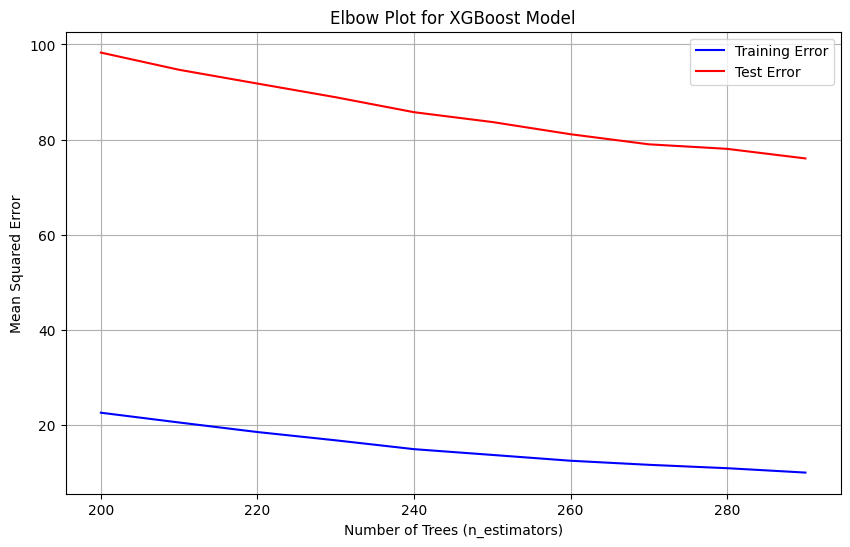

In [220]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the range of n_estimators to test
# n_estimators_range = range(200, 501, 50) 
# n_estimators_range = range(100, 700, 25) # 200-300 is the best range
n_estimators_range = range(200, 300, 10)
train_errors = []
test_errors = []

# Train models with different n_estimators
for n in n_estimators_range:
    model = XGBRegressor(
        n_estimators=n,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Calculate errors
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, train_pred))
    test_errors.append(mean_squared_error(y_test, test_pred))

# Create elbow plot
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_errors, 'b-', label='Training Error')
plt.plot(n_estimators_range, test_errors, 'r-', label='Test Error')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Squared Error')
plt.title('Elbow Plot for XGBoost Model')
plt.legend()
plt.grid(True)
plt.show()



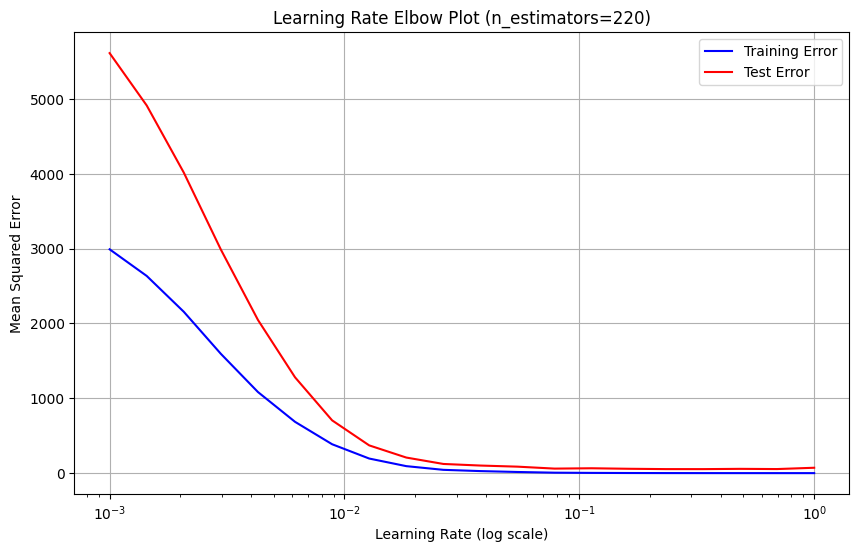

In [221]:
# Define learning rates to test (logarithmic scale from 0.001 to 1.0)
learning_rates = np.logspace(-3, 0, 20)  # 20 values between 0.001 and 1.0

train_errors = []
test_errors = []

for eta in learning_rates:
    model = XGBRegressor(
        n_estimators=220,       # Using optimal value from your plot
        learning_rate=eta,
        max_depth=6,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Record errors
    train_errors.append(mean_squared_error(y_train, model.predict(X_train)))
    test_errors.append(mean_squared_error(y_test, model.predict(X_test)))

# Plot
plt.figure(figsize=(10, 6))
plt.semilogx(learning_rates, train_errors, 'b-', label='Training Error')
plt.semilogx(learning_rates, test_errors, 'r-', label='Test Error')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('Learning Rate Elbow Plot (n_estimators=220)')
plt.legend()
plt.grid(True)
plt.show()

In [222]:
import numpy as np

# Assuming you have these lists from your plot code
learning_rates = np.logspace(-3, 0, 20)  # 0.001 to 1.0


# Find learning rate with minimum test error
optimal_idx = np.argmin(test_errors)
best_learning_rate = learning_rates[optimal_idx]
print(f"Optimal learning rate: {best_learning_rate:.3f}")

Optimal learning rate: 0.336


In [223]:
# ------------------
# Final Model Training
# ------------------
final_model = XGBRegressor(
    n_estimators=220,
    learning_rate=0.001,
    max_depth=6,
    random_state=42
)
final_model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

RMSE: 8.471
R²:   0.990


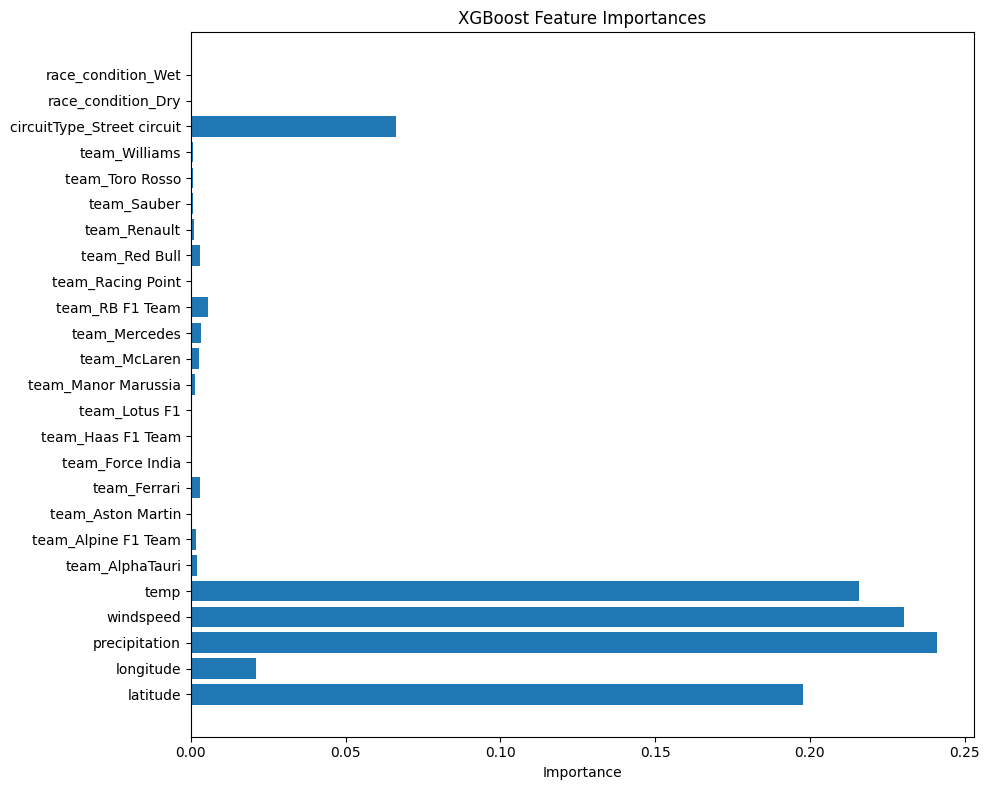

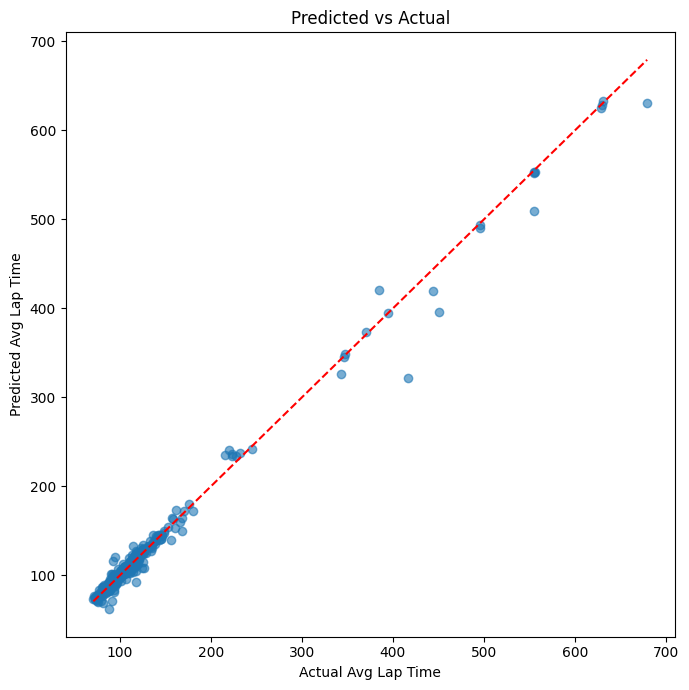

In [224]:
# ------------------
# Evaluation
# ------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.3f}')
print(f'R²:   {r2:.3f}')

# ------------------
# Feature Importance
# ------------------
importances = model.feature_importances_
feat_names = X_encoded.columns

plt.figure(figsize=(10, 8))
plt.barh(feat_names, importances)
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()

# ------------------
# Predicted vs Actual
# ------------------
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Avg Lap Time')
plt.ylabel('Predicted Avg Lap Time')
plt.title('Predicted vs Actual')
plt.tight_layout()
plt.show()


In [225]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Generate predictions
y_pred = final_model.predict(X_test)

# Calculate metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f} seconds")

Mean Squared Error: 5612.88
R² Score: 0.25
Mean Absolute Error: 31.66 seconds


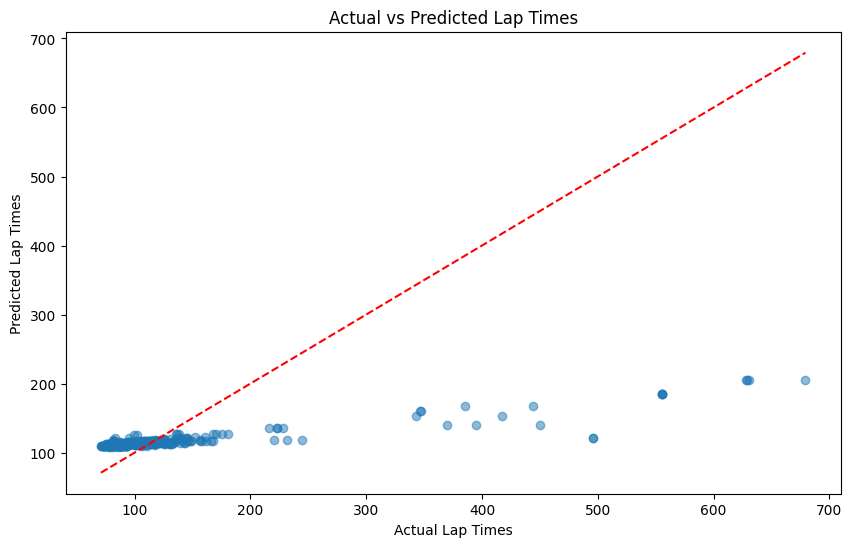

In [226]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Lap Times')
plt.ylabel('Predicted Lap Times')
plt.title('Actual vs Predicted Lap Times')
plt.show()

In [228]:
# Example: Compare team performances
team_effects = pd.DataFrame({
    'feature': [f for f in final_model.feature_names_in_ if 'team_' in f],
    'importance': final_model.feature_importances_[[i for i,name in enumerate(final_model.feature_names_in_) if 'team_' in name]]
}).sort_values('importance', ascending=False)

print("Team Performance Impact:")
print(team_effects.head(10))

Team Performance Impact:
                feature  importance
14          team_Sauber    0.000117
16        team_Williams    0.000095
3          team_Ferrari    0.000053
4      team_Force India    0.000015
9         team_Mercedes    0.000014
15      team_Toro Rosso    0.000006
8          team_McLaren    0.000002
0       team_AlphaTauri    0.000000
2     team_Aston Martin    0.000000
7   team_Manor Marussia    0.000000


In [229]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_estimators=500),
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error'
)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=500,
                                          n_jobs=None, num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_squared_error')

In [230]:
best_params = search.best_params_
print("Best parameters found:")
print(best_params)

Best parameters found:
{'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}


In [231]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

best_params = {
    'subsample': 0.8,
    'min_child_weight': 3, 
    'max_depth': 7,
    'learning_rate': 0.05,
    'gamma': 0,
    'colsample_bytree': 1.0
}

op_model = XGBRegressor(
    n_estimators=1000,  # Increased with early stopping
    early_stopping_rounds=50,
    **best_params,
    random_state=42
)

# Train with early stopping
op_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100  # Prints progress every 100 trees
)

[0]	validation_0-rmse:83.59558
[100]	validation_0-rmse:10.95934
[200]	validation_0-rmse:8.31160
[300]	validation_0-rmse:7.80401
[386]	validation_0-rmse:7.75172


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

Final MSE: 59.68
Final R²: 0.99


<Axes: ylabel='Feature'>

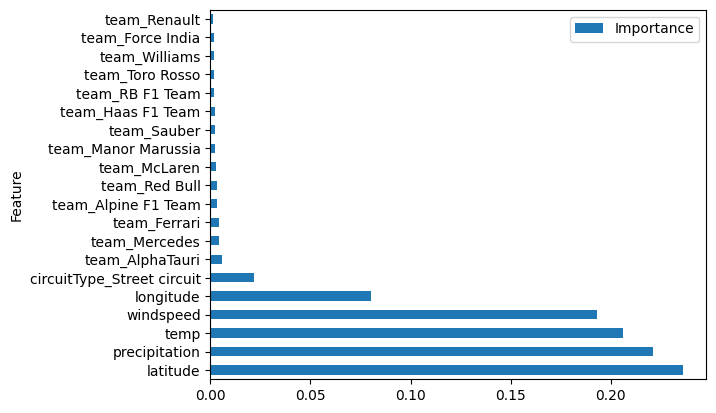

In [232]:
y_pred = op_model.predict(X_test)
print(f"Final MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Final R²: {r2_score(y_test, y_pred):.2f}")

# Feature Importance Visualization
pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': op_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20).plot.barh(x='Feature', y='Importance')

╔════════════════════════════╗
║      FINAL MODEL REPORT    ║
╠═══════════════╦════════════╣
║ MSE           ║ 59.6795    ║
║ MAE (seconds) ║ 3.5130    ║
║ R² Score      ║ 0.992050  ║
╚═══════════════╩════════════╝


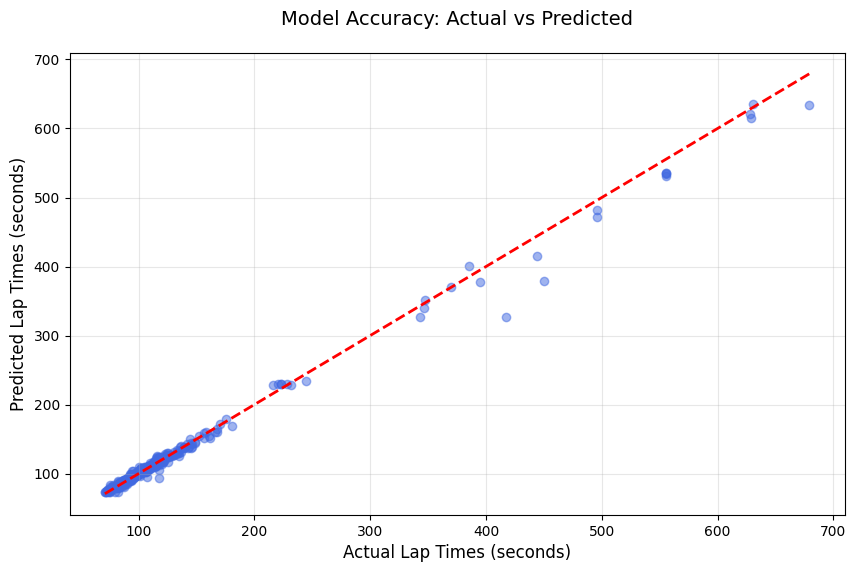

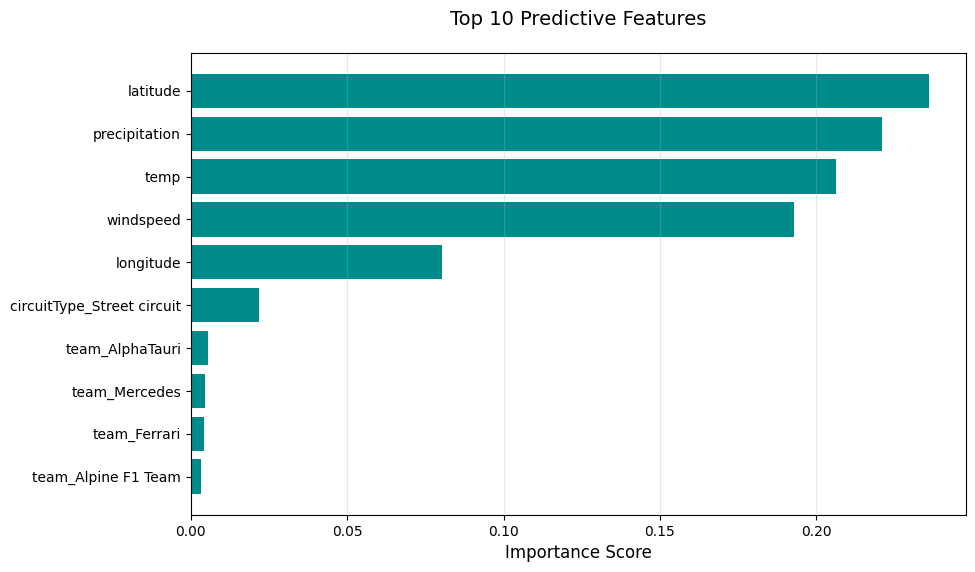

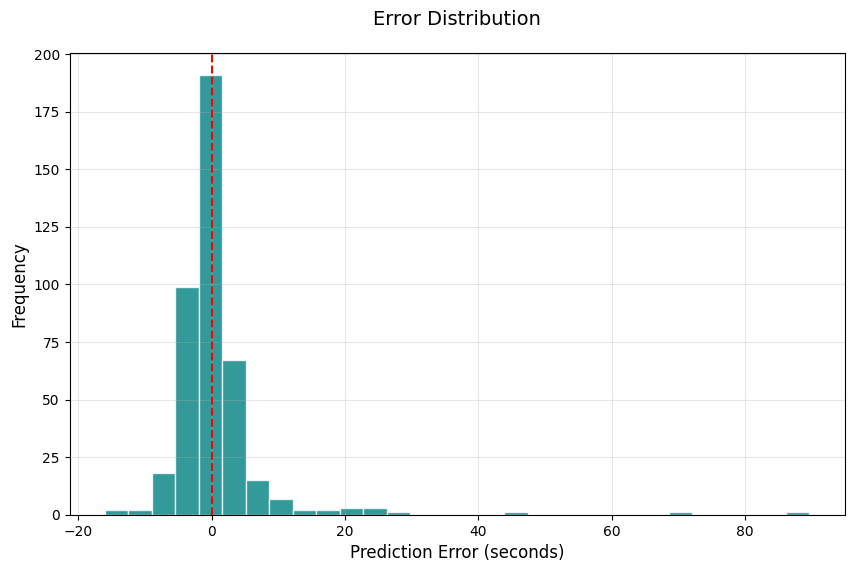

In [233]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Key Metrics
y_pred = op_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("╔════════════════════════════╗")
print("║      FINAL MODEL REPORT    ║")
print("╠═══════════════╦════════════╣")
print(f"║ MSE           ║ {mse:.4f}    ║")
print(f"║ MAE (seconds) ║ {mae:.4f}    ║")
print(f"║ R² Score      ║ {r2:.6f}  ║")
print("╚═══════════════╩════════════╝")

# 2. Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         '--', color='red', linewidth=2)
plt.xlabel('Actual Lap Times (seconds)', fontsize=12)
plt.ylabel('Predicted Lap Times (seconds)', fontsize=12)
plt.title('Model Accuracy: Actual vs Predicted', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.show()

# 3. Top 10 Feature Importances
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': op_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color='darkcyan')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Predictive Features', fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.grid(True, axis='x', alpha=0.3)
plt.show()

# 4. Error Distribution Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='teal', edgecolor='white', alpha=0.8)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Prediction Error (seconds)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Error Distribution', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.show()

In [235]:
import joblib
joblib.dump(op_model, 'f1_lap_time_predictor.joblib')

['f1_lap_time_predictor.joblib']

In [244]:
testing_df.columns

Index(['team', 'avg_lap_time', 'latitude', 'longitude', 'circuitType',
       'precipitation', 'windspeed', 'temp', 'race_condition'],
      dtype='object')

In [245]:
import pandas as pd

# Ensure all the same columns are in the testing data as in training data
def align_features(testing_df, model_columns):
    # One-hot encode categorical variables (team, circuitType, race_condition)
    X_test = pd.get_dummies(testing_df, drop_first=True)

    # Add missing columns (those present in model_columns but missing in X_test)
    missing_cols = set(model_columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0  # Add missing columns with 0 values (for missing categories)

    # Reorder columns to match the model's expected order
    X_test = X_test[model_columns]

    return X_test

# Define the columns expected by the model (from training set)
model_columns = ['latitude', 'longitude', 'precipitation', 'windspeed', 'temp',
                 'team_AlphaTauri', 'team_Alpine F1 Team', 'team_Aston Martin', 'team_Ferrari',
                 'team_Force India', 'team_Haas F1 Team', 'team_Lotus F1', 'team_Manor Marussia',
                 'team_McLaren', 'team_Mercedes', 'team_RB F1 Team', 'team_Racing Point', 'team_Red Bull',
                 'team_Renault', 'team_Sauber', 'team_Toro Rosso', 'team_Williams', 'circuitType_Street circuit',
                 'race_condition_Dry', 'race_condition_Wet']

# Now apply the function to align features in the testing_df
X_test_aligned = align_features(testing_df, model_columns)

# Extract the target column and apply prediction
y_true = testing_df['avg_lap_time']



In [246]:
# Apply transformations to the testing dataframe (testing_df)
testing_df['latitude'] = pd.to_numeric(testing_df['latitude'], errors='coerce')
testing_df['longitude'] = pd.to_numeric(testing_df['longitude'], errors='coerce')

# Prepare features and remove the target column
y_true = testing_df['avg_lap_time']
X_test = testing_df.drop(columns=['avg_lap_time'])  # Remove target column
predictions = op_model.predict(X_test_aligned)

# Create results DataFrame
results = pd.DataFrame({
    'Actual_Lap_Time': y_true,
    'Predicted_Lap_Time': predictions,
    'Difference': predictions - y_true
})

# Display results
print(results.head())


      Actual_Lap_Time  Predicted_Lap_Time  Difference
2075         100.5008           95.373421   -5.127379
2076          99.9012           97.249725   -2.651475
2077         101.1873           98.566536   -2.620764
2078         101.7715           98.776596   -2.994904
2079         101.0788           94.920982   -6.157818


In [247]:
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print("╔════════════════════════════╗")
print("║       Model Evaluation     ║")
print("╠═══════════════╦════════════╣")
print(f"║ MAE (seconds) ║ {mae:.4f}    ║")
print(f"║ R² Score      ║ {r2:.6f}  ║")
print("╚═══════════════╩════════════╝\n")

# 7. Show sample predictions
print("Sample Predictions:")
print(results.head(10))

╔════════════════════════════╗
║       Model Evaluation     ║
╠═══════════════╦════════════╣
║ MAE (seconds) ║ 10.9070    ║
║ R² Score      ║ -0.305149  ║
╚═══════════════╩════════════╝

Sample Predictions:
      Actual_Lap_Time  Predicted_Lap_Time  Difference
2075         100.5008           95.373421   -5.127379
2076          99.9012           97.249725   -2.651475
2077         101.1873           98.566536   -2.620764
2078         101.7715           98.776596   -2.994904
2079         101.0788           94.920982   -6.157818
2080         101.7315           95.086983   -6.644517
2081         102.1497           99.033348   -3.116352
2082         102.6939          100.749138   -1.944762
2083         105.1230           99.642647   -5.480353
2084         103.5038          104.142090    0.638290


import joblib
joblib.dump(final_model, 'f1_lap_time_predictor.joblib')